In [1]:
! pip install finta

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import yfinance as yahooFinance
from datetime import datetime, timedelta
from pandas.tseries.offsets import DateOffset
from finta import TA

from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import VotingRegressor

import xgboost as xgb
from xgboost.sklearn import XGBRegressor

import warnings
warnings.filterwarnings("ignore")


C:\Users\Asia\anaconda3\envs\dev\lib\site-packages\yfinance\base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [3]:
end_date= "2024-03-01"
start_date="2012-03-01"
ticker= "TGT" # "input('Enter ticker from the list: "["AAPL","MSFT","S&P500"]"  ') 
ticker_df = yahooFinance.download(ticker, start=start_date, end=end_date, period='1d')
display(ticker_df.head())
display(ticker_df.tail())

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-03-01,56.590000,56.910000,56.200001,56.759998,40.712326,8223000
2012-03-02,56.590000,56.900002,56.360001,56.590000,40.590385,3462100
2012-03-05,56.709999,56.860001,56.119999,56.700001,40.669296,4053900
2012-03-06,56.240002,56.689999,56.119999,56.490002,40.518669,6344500
2012-03-07,56.529999,56.680000,56.259998,56.639999,40.626244,4776600


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-02-23,150.979996,152.779999,150.410004,151.479996,151.479996,3503600
2024-02-26,150.610001,150.949997,149.100006,150.149994,150.149994,3856900
2024-02-27,150.789993,152.309998,150.449997,151.990005,151.990005,2851700
2024-02-28,151.330002,152.250000,150.649994,151.440002,151.440002,2298300
2024-02-29,152.389999,153.649994,152.000000,152.919998,152.919998,4447800


In [4]:
ticker_df.shape

(3019, 6)

In [5]:
ticker_df=ticker_df.drop("Adj Close",axis=1)
column=["open","high","low","close","volume"]
ticker_df.columns=column

In [6]:
# to determine the trend
sma_window=[7,20,30,50,100,200]
for i in sma_window:
    ticker_df[f"sma_{i}"]=ticker_df["close"].rolling(window=i).mean()
    
std_window=[7,20,30,50,100,200]
for i in std_window:
    ticker_df[f"{i}_day_std"]=ticker_df["close"].rolling(window=i).std()
    
for i in sma_window:
    ticker_df[f"{i}_DEMA"]=TA.DEMA(ticker_df, i)
    
ticker_df[["MACD","MACD_Signal"]]=TA.MACD(ticker_df)
ticker_df["RSA"]=TA.RSI(ticker_df,14)
ticker_df["STOCH"]=TA.STOCHRSI(ticker_df,14)
ticker_df["RSI"]=TA.RSI(ticker_df,14)



In [7]:
# calculate Daily Variation
window= 1
ticker_df[f"close_{window}days"]=ticker_df["close"].shift(-window)

In [8]:
# calculate downward pressure on index
ticker_df["high_close"]=ticker_df["high"]-ticker_df["close"]
# calculate upward pressure on index
ticker_df["open-low"]=ticker_df["open"]-ticker_df["low"]
ticker_df

,open,high,low,close,volume,sma_7,sma_20,sma_30,sma_50,sma_100,...,100_DEMA,200_DEMA,MACD,MACD_Signal,RSA,STOCH,RSI,close_1days,high_close,open-low
Date,,,,,,,,,,,,,,,,,,,,,
2012-03-01,56.590000,56.910000,56.200001,56.759998,8223000,NaN,NaN,NaN,NaN,NaN,...,56.759998,56.759998,0.000000,0.000000,NaN,NaN,NaN,56.590000,0.150002,0.389999
2012-03-02,56.590000,56.900002,56.360001,56.590000,3462100,NaN,NaN,NaN,NaN,NaN,...,56.631654,56.632076,-0.003814,-0.002119,0.000000,NaN,0.000000,56.700001,0.310001,0.230000
2012-03-05,56.709999,56.860001,56.119999,56.700001,4053900,NaN,NaN,NaN,NaN,NaN,...,56.660695,56.660623,-0.001449,-0.001844,41.067062,NaN,41.067062,56.490002,0.160000,0.590000
2012-03-06,56.240002,56.689999,56.119999,56.490002,6344500,NaN,NaN,NaN,NaN,NaN,...,56.579840,56.580752,-0.007919,-0.003902,22.266928,NaN,22.266928,56.639999,0.199997,0.120003
2012-03-07,56.529999,56.680000,56.259998,56.639999,4776600,NaN,NaN,NaN,NaN,NaN,...,56.593470,56.593794,-0.005300,-0.004318,42.511210,NaN,42.511210,57.230000,0.040001,0.270000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-23,150.979996,152.779999,150.410004,151.479996,3503600,148.781427,145.897999,143.962000,142.538199,130.0171,...,141.310790,129.034883,2.595179,2.259615,64.405685,0.673349,64.405685,150.149994,1.300003,0.569992
2024-02-26,150.610001,150.949997,149.100006,150.149994,3856900,149.512854,146.278999,144.232999,142.827999,130.4517,...,141.750961,129.372358,2.570690,2.321830,60.654395,0.678406,60.654395,151.990005,0.800003,1.509995
2024-02-27,150.789993,152.309998,150.449997,151.990005,2851700,150.321426,146.802499,144.602333,143.100199,130.9000,...,142.249316,129.741641,2.668989,2.391262,63.796096,0.682839,63.796096,151.440002,0.319992,0.339996


In [9]:

lagging= [30,45,60,90,120,150,200]
for lag in lagging:
    ticker_df[f"lag_{lag}"]=ticker_df["close"].shift((lag))

In [10]:
ticker_df["vol_change"]=ticker_df["volume"].pct_change()

In [11]:
ticker_df.head(61)

,open,high,low,close,volume,sma_7,sma_20,sma_30,sma_50,sma_100,...,high_close,open-low,lag_30,lag_45,lag_60,lag_90,lag_120,lag_150,lag_200,vol_change
Date,,,,,,,,,,,,,,,,,,,,,
2012-03-01,56.590000,56.910000,56.200001,56.759998,8223000,NaN,NaN,NaN,NaN,NaN,...,0.150002,0.389999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-03-02,56.590000,56.900002,56.360001,56.590000,3462100,NaN,NaN,NaN,NaN,NaN,...,0.310001,0.230000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.578974
2012-03-05,56.709999,56.860001,56.119999,56.700001,4053900,NaN,NaN,NaN,NaN,NaN,...,0.160000,0.590000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.170937
2012-03-06,56.240002,56.689999,56.119999,56.490002,6344500,NaN,NaN,NaN,NaN,NaN,...,0.199997,0.120003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.565036
2012-03-07,56.529999,56.680000,56.259998,56.639999,4776600,NaN,NaN,NaN,NaN,NaN,...,0.040001,0.270000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.247127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-05-21,55.430000,55.900002,54.930000,55.830002,4779400,55.264286,56.2095,56.541000,57.1842,NaN,...,0.070000,0.500000,57.520000,58.410000,NaN,NaN,NaN,NaN,NaN,-0.331019
2012-05-22,55.889999,56.900002,55.810001,56.669998,5777400,55.441429,56.2065,56.550000,57.1580,NaN,...,0.230003,0.079998,56.400002,58.369999,NaN,NaN,NaN,NaN,NaN,0.208813
2012-05-23,56.240002,56.889999,55.939999,56.779999,3956300,55.707143,56.2040,56.536000,57.1240,NaN,...,0.110001,0.300003,57.200001,58.009998,NaN,NaN,NaN,NaN,NaN,-0.315211


In [12]:
ticker_df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'sma_7', 'sma_20', 'sma_30',
       'sma_50', 'sma_100', 'sma_200', '7_day_std', '20_day_std', '30_day_std',
       '50_day_std', '100_day_std', '200_day_std', '7_DEMA', '20_DEMA',
       '30_DEMA', '50_DEMA', '100_DEMA', '200_DEMA', 'MACD', 'MACD_Signal',
       'RSA', 'STOCH', 'RSI', 'close_1days', 'high_close', 'open-low',
       'lag_30', 'lag_45', 'lag_60', 'lag_90', 'lag_120', 'lag_150', 'lag_200',
       'vol_change'],
      dtype='object')

In [13]:
ticker_df=ticker_df.drop(columns=['open', 'high', 'low'])

In [14]:
ticker_df.columns

Index(['close', 'volume', 'sma_7', 'sma_20', 'sma_30', 'sma_50', 'sma_100',
       'sma_200', '7_day_std', '20_day_std', '30_day_std', '50_day_std',
       '100_day_std', '200_day_std', '7_DEMA', '20_DEMA', '30_DEMA', '50_DEMA',
       '100_DEMA', '200_DEMA', 'MACD', 'MACD_Signal', 'RSA', 'STOCH', 'RSI',
       'close_1days', 'high_close', 'open-low', 'lag_30', 'lag_45', 'lag_60',
       'lag_90', 'lag_120', 'lag_150', 'lag_200', 'vol_change'],
      dtype='object')

In [15]:
ticker_df.shape

(3019, 36)

In [16]:
ticker_df=ticker_df.dropna()
ticker_df.isnull().sum()

close          0
volume         0
sma_7          0
sma_20         0
sma_30         0
sma_50         0
sma_100        0
sma_200        0
7_day_std      0
20_day_std     0
30_day_std     0
50_day_std     0
100_day_std    0
200_day_std    0
7_DEMA         0
20_DEMA        0
30_DEMA        0
50_DEMA        0
100_DEMA       0
200_DEMA       0
MACD           0
MACD_Signal    0
RSA            0
STOCH          0
RSI            0
close_1days    0
high_close     0
open-low       0
lag_30         0
lag_45         0
lag_60         0
lag_90         0
lag_120        0
lag_150        0
lag_200        0
vol_change     0
dtype: int64

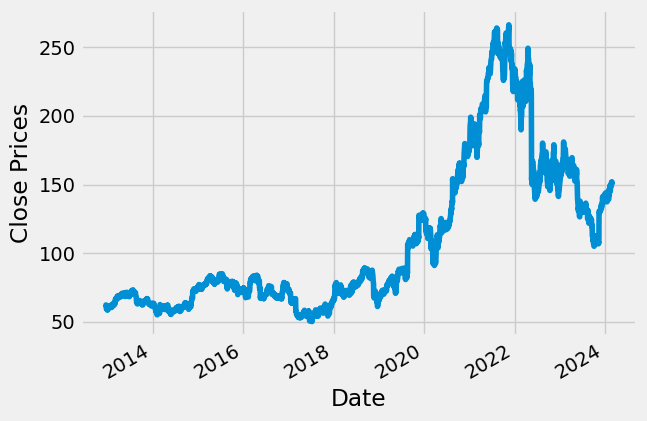

In [17]:
ticker_df['close'].plot()
plt.ylabel("Close Prices")
plt.show()

In [18]:
# ticker_df['return'].plot.hist(bins=50)
# plt.xlabel("1 day percent change in returns")
# plt.show()

In [19]:
ticker_df.corr()

,close,volume,sma_7,sma_20,sma_30,sma_50,sma_100,sma_200,7_day_std,20_day_std,...,high_close,open-low,lag_30,lag_45,lag_60,lag_90,lag_120,lag_150,lag_200,vol_change
close,1.000000,-0.222055,0.998142,0.993612,0.989804,0.982721,0.968239,0.928726,0.512546,0.588989,...,0.451632,0.432985,0.967459,0.953032,0.943156,0.916703,0.882055,0.841461,0.785192,-0.009687
volume,-0.222055,1.000000,-0.214589,-0.203652,-0.197237,-0.190932,-0.180270,-0.165606,0.187546,0.031473,...,0.127996,0.155423,-0.181023,-0.178511,-0.173622,-0.159319,-0.154780,-0.133588,-0.130253,0.653368
sma_7,0.998142,-0.214589,1.000000,0.997084,0.993656,0.986642,0.972144,0.933142,0.522566,0.595119,...,0.472129,0.456071,0.971864,0.956486,0.946127,0.921250,0.887151,0.846115,0.790187,-0.005781
sma_20,0.993612,-0.203652,0.997084,1.000000,0.998800,0.993386,0.979450,0.942001,0.537406,0.610880,...,0.478745,0.463796,0.981484,0.965194,0.952718,0.929942,0.897377,0.856591,0.799752,-0.003858
sma_30,0.989804,-0.197237,0.993656,0.998800,1.000000,0.997056,0.984319,0.948478,0.545708,0.622594,...,0.482444,0.466735,0.988761,0.972396,0.958586,0.936278,0.905118,0.865301,0.806839,-0.002672
sma_50,0.982721,-0.190932,0.986642,0.993386,0.997056,1.000000,0.992042,0.960360,0.551388,0.634096,...,0.485879,0.470372,0.995104,0.986529,0.972075,0.947571,0.919802,0.882324,0.821002,-0.002778
sma_100,0.968239,-0.180270,0.972144,0.979450,0.984319,0.992042,1.000000,0.982668,0.565241,0.643473,...,0.493237,0.477753,0.987473,0.990190,0.989537,0.976964,0.949989,0.918911,0.859238,-0.002983
sma_200,0.928726,-0.165606,0.933142,0.942001,0.948478,0.960360,0.982668,1.000000,0.583912,0.656294,...,0.496809,0.483349,0.957553,0.968092,0.976281,0.985606,0.984197,0.971790,0.931046,-0.001192
7_day_std,0.512546,0.187546,0.522566,0.537406,0.545708,0.551388,0.565241,0.583912,1.000000,0.655585,...,0.390556,0.400133,0.554162,0.553476,0.552348,0.574989,0.574248,0.583442,0.566300,0.030361
20_day_std,0.588989,0.031473,0.595119,0.610880,0.622594,0.634096,0.643473,0.656294,0.655585,1.000000,...,0.348273,0.348559,0.648050,0.636308,0.634085,0.639888,0.634011,0.646759,0.635872,0.013227


In [20]:
# feature_col = ticker_df.drop("close_1days", axis='columns')

In [21]:
# setting feature columns and target variable
X = ticker_df.drop(["close_1days","close","volume"], axis='columns')
y = ticker_df['close_1days']

In [22]:
from pandas.tseries.offsets import DateOffset
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

# Select the ending period for the training data with an offset of 110 months
training_end = X.index.min() + DateOffset(months =118)

# Display the training end date

# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

# Review the X_test DataFrame
display(X_test.head())
display(X_test.tail())

2012-12-17 00:00:00


,sma_7,sma_20,sma_30,sma_50,sma_100,sma_200,7_day_std,20_day_std,30_day_std,50_day_std,...,high_close,open-low,lag_30,lag_45,lag_60,lag_90,lag_120,lag_150,lag_200,vol_change
Date,,,,,,,,,,,,,,,,,,,,,
2022-10-17,151.880001,153.0965,158.039333,161.5692,157.1144,187.31415,3.266328,3.732911,8.060034,8.397849,...,1.750000,1.060013,164.600006,172.479996,157.740005,156.699997,236.500000,208.759995,231.910004,-0.332871
2022-10-18,152.578572,152.9565,157.827666,161.3744,157.1225,186.94310,3.851584,3.504720,7.992610,8.382966,...,3.900009,0.520004,163.580002,173.389999,157.490005,154.550003,230.970001,215.350006,231.440002,0.750928
2022-10-19,152.905714,152.7745,157.314333,161.1798,157.0444,186.56030,3.997735,3.258594,7.617103,8.407143,...,2.800003,3.059998,170.789993,180.190002,151.809998,149.669998,236.389999,215.589996,231.949997,-0.530593
2022-10-20,152.891427,152.8465,156.731000,160.8744,156.9170,186.16145,3.991261,3.278754,7.115139,8.369699,...,4.760010,2.559998,171.899994,175.339996,154.600006,144.809998,228.649994,220.630005,234.169998,0.179322
2022-10-21,153.609998,153.1755,156.249000,160.6662,156.8901,185.81310,4.655272,3.570889,6.381427,8.277181,...,0.069992,0.239990,173.649994,173.050003,159.419998,142.699997,229.779999,226.050003,228.860001,0.139132


,sma_7,sma_20,sma_30,sma_50,sma_100,sma_200,7_day_std,20_day_std,30_day_std,50_day_std,...,high_close,open-low,lag_30,lag_45,lag_60,lag_90,lag_120,lag_150,lag_200,vol_change
Date,,,,,,,,,,,,,,,,,,,,,
2024-02-22,148.014284,145.432999,143.715666,142.243799,129.6080,130.90415,2.138705,3.301199,3.802710,3.729063,...,0.639999,0.799988,143.770004,138.369995,131.460007,110.800003,126.949997,132.699997,156.300003,0.085023
2024-02-23,148.781427,145.897999,143.962000,142.538199,130.0171,130.87905,2.298900,3.469567,4.058544,3.865840,...,1.300003,0.569992,144.089996,137.720001,131.330002,111.980003,126.550003,134.639999,156.500000,0.399313
2024-02-26,149.512854,146.278999,144.232999,142.827999,130.4517,130.84270,1.620931,3.498517,4.193585,3.882777,...,0.800003,1.509995,142.020004,139.580002,131.669998,111.389999,125.519997,134.080002,157.419998,0.100839
2024-02-27,150.321426,146.802499,144.602333,143.100199,130.9000,130.81400,1.094967,3.532104,4.374830,4.038526,...,0.319992,0.339996,140.910004,136.899994,131.320007,112.559998,125.190002,135.410004,157.729996,-0.260624
2024-02-28,150.582855,147.348499,144.947999,143.306199,131.3482,130.77685,1.115077,3.349107,4.494160,4.196119,...,0.809998,0.680008,141.070007,139.369995,133.809998,110.209999,123.709999,133.600006,158.869995,-0.194060


In [23]:
print(len(y_test))

343


In [24]:
# Create ain= StandardScaler instance
scaler = StandardScaler()

# Fit the scaler to the features training dataset
X_scaler = scaler.fit(X_train)

# Fit the scaler to the features training dataset
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [25]:
X_test_scaled

array([[ 0.86096626,  0.88881158,  0.98182413, ...,  2.10270531,
         2.72712791, -0.72359252],
       [ 0.87330557,  0.88633269,  0.97806828, ...,  2.22580311,
         2.71790119,  1.11759083],
       [ 0.87908408,  0.88311014,  0.9689596 , ...,  2.230286  ,
         2.72791302, -1.05948601],
       ...,
       [ 0.81915385,  0.76809865,  0.73684207, ...,  0.70772406,
         1.26479496,  0.01320464],
       [ 0.83343617,  0.77736791,  0.74339559, ...,  0.73256777,
         1.2708806 , -0.60085668],
       [ 0.83805396,  0.78703557,  0.74952916, ...,  0.69875801,
         1.29326023, -0.48777605]])

## RandomForestRegressor

## RandomForestRegressor

In [26]:
rf= RandomForestRegressor()

In [27]:
param_grid_xgb={"n_estimators": [100],
            "max_depth": [6],
            "max_features" :[ 5]
           }

# rf_model = RegressorModel(clf=rf, params=rf_params)

In [28]:
gs_csv=GridSearchCV(estimator=rf,
                    param_grid=param_grid_xgb,
                    scoring=["r2"],
                    refit="r2",
                    cv=5,
                    verbose=4)
                    
                    

In [29]:
gs_csv.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=6, max_features=5, n_estimators=100; r2: (test=0.862) total time=   2.2s
[CV 2/5] END max_depth=6, max_features=5, n_estimators=100; r2: (test=0.881) total time=   2.0s
[CV 3/5] END max_depth=6, max_features=5, n_estimators=100; r2: (test=0.916) total time=   2.0s
[CV 4/5] END max_depth=6, max_features=5, n_estimators=100; r2: (test=0.752) total time=   2.0s
[CV 5/5] END max_depth=6, max_features=5, n_estimators=100; r2: (test=-1.685) total time=   1.9s


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [6], 'max_features': [5],
                         'n_estimators': [100]},
             refit='r2', scoring=['r2'], verbose=4)

In [30]:
rf_best=gs_csv.best_estimator_

In [31]:
#print(gs_csv.best_estimator)
print(gs_csv.best_params_)

{'max_depth': 6, 'max_features': 5, 'n_estimators': 100}


In [32]:
print(gs_csv.best_score_)

0.3451681992582777


In [33]:
df=pd.DataFrame(gs_csv.cv_results_)
df=df.sort_values("rank_test_r2")
df.to_csv("gs.csv")
                  

In [34]:
from sklearn import metrics
predictions=rf_best.predict(X_test_scaled)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R2 Score:', metrics.r2_score(y_test, predictions))
rf_r2= round((metrics.r2_score(y_test, predictions)),4)
rf_mse=round((metrics.mean_squared_error(y_test, predictions)),4)

Mean Absolute Error: 7.159718168527003
Mean Squared Error: 79.82017860916446
Root Mean Squared Error: 8.934213933478672
R2 Score: 0.7699818664496392


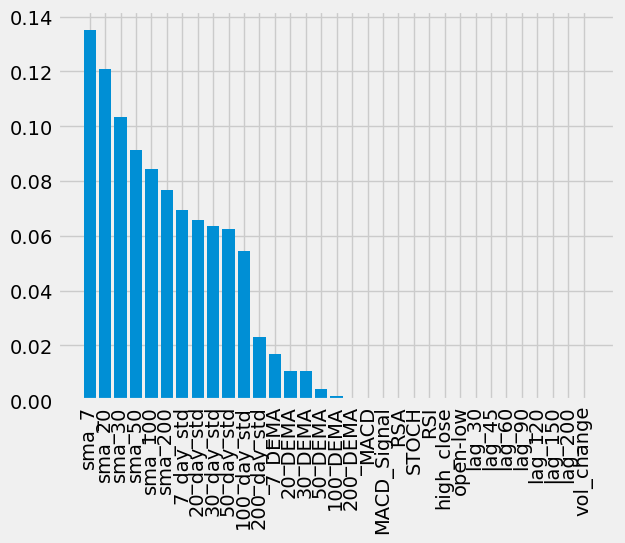

In [35]:
importances = rf_best.feature_importances_
sorted_index = np.argsort(importances)[::-1]
x_values = range(len(importances))
labels = X.columns.values.tolist()
plt.bar(x_values, importances[sorted_index], tick_label=labels)
plt.xticks(rotation=90)
plt.show()

<Axes: xlabel='Date'>

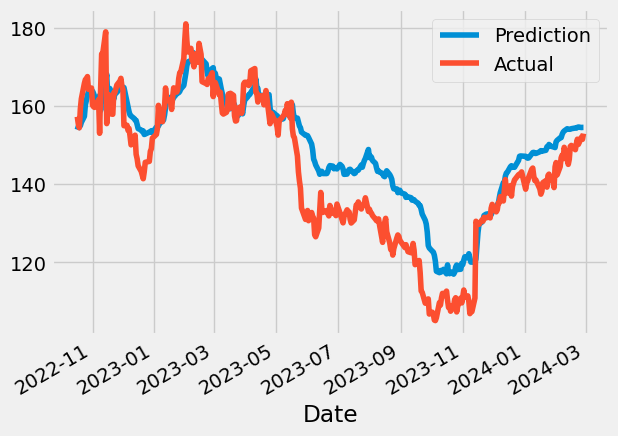

In [36]:
df1=pd.DataFrame({"Prediction": predictions, "Actual": y_test})
df1.plot()

## XGBoost Regressor

In [37]:

xgb_model= xgb.XGBRegressor()


In [38]:
param_grid_xgb= {"learning_rate": (0.05, 0.10, 0.15),
                        "max_depth": [3],
                        "min_child_weight": [4],
                        'subsample': [0.7],
                        "n_estimators": [500]}
           

In [39]:
gs_csv_xgb=GridSearchCV(estimator=xgb_model,
                    param_grid=param_grid_xgb,
                    cv=5,
                    verbose=True)

In [40]:
gs_csv_xgb.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': (0.05, 0.1, 0.15), 'max_depth': [3],
                         'min_child_weight': [4], 'n_estimators': [500],
                         'subsample': [0.7]},
             verbose=True)

In [41]:
xgb_best=gs_csv_xgb.best_estimator_

In [42]:
#print(gs_csv.best_estimator)
print(gs_csv_xgb.best_params_)

{'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 500, 'subsample': 0.7}


In [43]:
print(gs_csv_xgb.best_score_)

0.39884812579005907


In [44]:
df=pd.DataFrame(gs_csv_xgb.cv_results_)
df=df.sort_values("rank_test_score")
df.to_csv("gs_xgb.csv")

In [45]:
predictions_xgb=xgb_best.predict(X_test_scaled)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions_xgb))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, predictions_xgb))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predictions_xgb)))
print('R2 Score:', metrics.r2_score(y_test, predictions_xgb))
xgb_r2= round((metrics.r2_score(y_test, predictions_xgb)),4)
xgb_mse=round((metrics.mean_squared_error(y_test, predictions_xgb)),4)

Mean Absolute Error: 3.1948624991814527
Mean Squared Error: 18.700686634998632
Root Mean Squared Error: 4.324429053065692
R2 Score: 0.9461101552158304


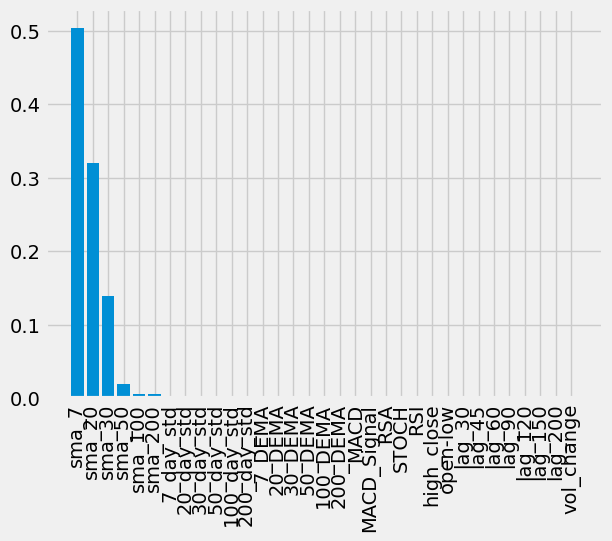

In [46]:
importances_xgb = xgb_best.feature_importances_
sorted_index = np.argsort(importances_xgb)[::-1]
x_values = range(len(importances_xgb))
labels =  X.columns.values.tolist()
plt.bar(x_values, importances_xgb[sorted_index], tick_label=labels)
plt.xticks(rotation=90)
plt.show()

<Axes: xlabel='Date'>

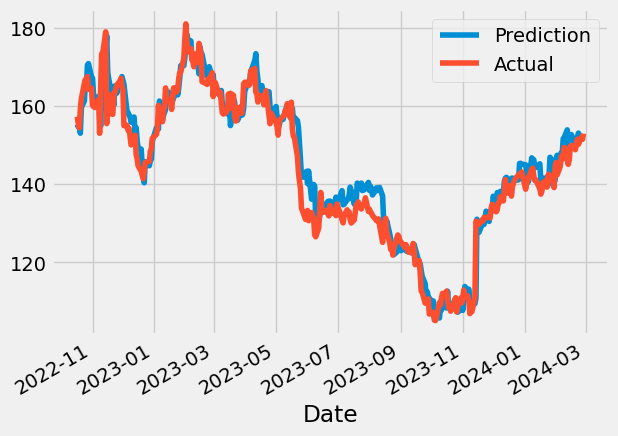

In [47]:
df2=pd.DataFrame({"Prediction": predictions_xgb, "Actual": y_test})
df2.plot()

In [48]:
# actual_price=
# total_df=pd.concat(

In [49]:
df2.tail()

,Prediction,Actual
Date,,
2024-02-22,151.968842,151.479996
2024-02-23,153.041656,150.149994
2024-02-26,151.560928,151.990005
2024-02-27,151.774155,151.440002
2024-02-28,151.768829,152.919998


## GradientBoost Regression

In [50]:
gb_model= GradientBoostingRegressor()
param_grid_gb= {'alpha':[0.05],
                        "max_depth": [3],
                        "learning_rate": [0.15],
                        'subsample': [0.7],
                        "n_estimators": [500]}


# {'alpha':[0.05,0.1,0.3,1,3,5,10],
#                         "max_depth": [3],
#                         "learning_rate": (0.05, 0.10, 0.15),
#                         'subsample': [0.7],
#                         "n_estimators": [500]}
           

In [51]:
gs_csv_gb=GridSearchCV(estimator=gb_model,
                    param_grid=param_grid_gb,
                    scoring=["r2"],
                    refit="r2",
                    cv=5,
                    verbose=True)
                    

In [52]:
gs_csv_gb.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'alpha': [0.05], 'learning_rate': [0.15],
                         'max_depth': [3], 'n_estimators': [500],
                         'subsample': [0.7]},
             refit='r2', scoring=['r2'], verbose=True)

In [53]:
gb_best=gs_csv_gb.best_estimator_

In [54]:
#print(gs_csv.best_estimator)
print(gs_csv_gb.best_params_)

{'alpha': 0.05, 'learning_rate': 0.15, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.7}


In [55]:
predictions_gb=gb_best.predict(X_test_scaled)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions_gb))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, predictions_gb))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predictions_gb)))
print('R2 Score:', metrics.r2_score(y_test, predictions_gb))
gb_r2= round((metrics.r2_score(y_test, predictions_gb)),4)
gb_mse=round((metrics.mean_squared_error(y_test, predictions_gb)),4)

Mean Absolute Error: 6.310682635949791
Mean Squared Error: 61.31187251001244
Root Mean Squared Error: 7.830189813153474
R2 Score: 0.8233173274607088


<Axes: xlabel='Date'>

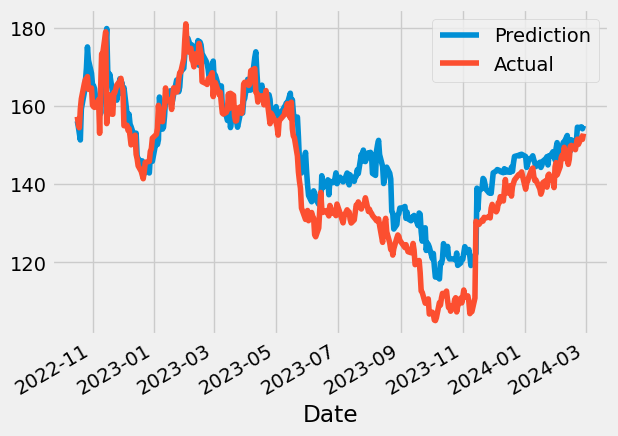

In [56]:
df3=pd.DataFrame({"Prediction": predictions_gb, "Actual": y_test})
df3.plot()

## LinearRegression

In [57]:

lr_model= LinearRegression()


In [58]:
param_grid_lrm= {'fit_intercept': [True, False], 'positive': [True, False]}
           

In [59]:
gs_csv_lrm=GridSearchCV(estimator=lr_model,
                    param_grid=param_grid_lrm,
                    scoring='neg_mean_squared_error',
                    cv=5,
                    verbose=True)
                    
                    

In [60]:
gs_csv_lrm.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False],
                         'positive': [True, False]},
             scoring='neg_mean_squared_error', verbose=True)

In [61]:
lrm_best=gs_csv_lrm.best_estimator_

In [62]:
#print(gs_csv.best_estimator)
print(gs_csv_lrm.best_params_)

{'fit_intercept': True, 'positive': False}


In [63]:
print(gs_csv_lrm.best_score_)

-6.486129274602052


In [64]:
df=pd.DataFrame(gs_csv_lrm.cv_results_)
df=df.sort_values("rank_test_score")
df.to_csv("gs_lrm.csv")

In [65]:
predictions_lrm=lrm_best.predict(X_test_scaled)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions_lrm))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, predictions_lrm))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predictions_lrm)))
print('R2 Score:', metrics.r2_score(y_test, predictions_lrm))
lrm_r2= round((metrics.r2_score(y_test, predictions_lrm)),4)
lrm_mse=round((metrics.mean_squared_error(y_test, predictions_lrm)),4)

Mean Absolute Error: 2.328338055456379
Mean Squared Error: 11.530912389668375
Root Mean Squared Error: 3.3957197160054853
R2 Score: 0.966771322838161


<Axes: xlabel='Date'>

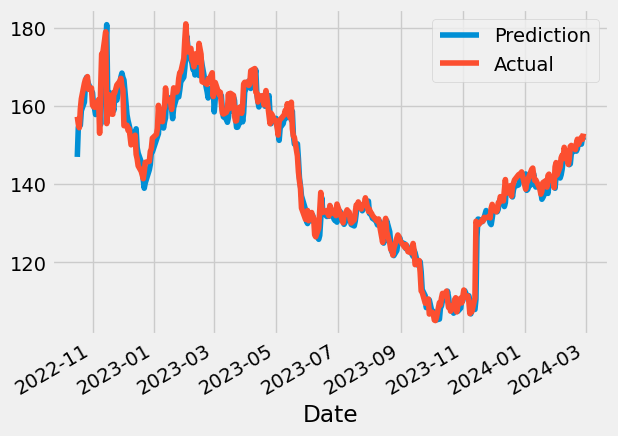

In [66]:
df4=pd.DataFrame({"Prediction": predictions_lrm, "Actual": y_test})
df4.plot()

## Ridge

In [67]:
ridge_model= Ridge()
param_grid_ridge= {'alpha':[0.05,0.1,0.3,1,3,5,10]}
                   

In [68]:
gs_csv_ridge=GridSearchCV(estimator=ridge_model,
                    param_grid=param_grid_ridge,
                    scoring='neg_mean_squared_error',
                    cv=5,
                    verbose=True)

In [69]:
gs_csv_ridge.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.05, 0.1, 0.3, 1, 3, 5, 10]},
             scoring='neg_mean_squared_error', verbose=True)

In [70]:
ridge_best=gs_csv_ridge.best_estimator_

In [71]:
predictions_ridge=ridge_best.predict(X_test_scaled)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions_ridge))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, predictions_ridge))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predictions_ridge)))
print('R2 Score:', metrics.r2_score(y_test, predictions_ridge))
ridge_r2= round((metrics.r2_score(y_test, predictions_ridge)),4)
ridge_mse=round((metrics.mean_squared_error(y_test, predictions_ridge)),4)

Mean Absolute Error: 2.387076310495039
Mean Squared Error: 11.710303773536225
Root Mean Squared Error: 3.422032111704422
R2 Score: 0.9662543699571816


In [72]:
# importances_ridge = ridge_best.feature_importances_
# sorted_index = np.argsort(importances_ridge)[::-1]
# x_values = range(len(importances_ridge))
# labels =  X.columns.values.tolist()
# plt.bar(x_values, importances_ridge[sorted_index], tick_label=labels)
# plt.xticks(rotation=90)
# plt.show()


<Axes: xlabel='Date'>

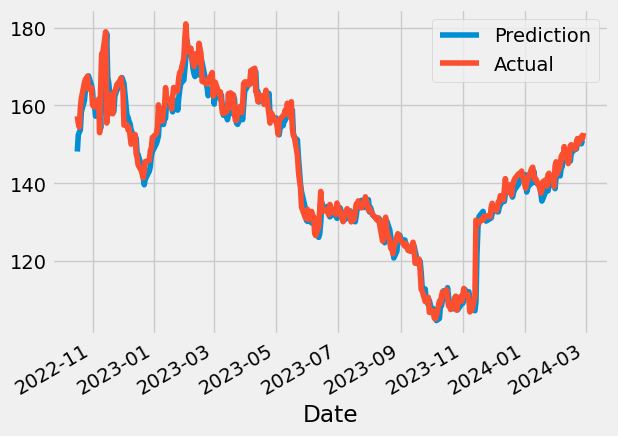

In [73]:
df5=pd.DataFrame({"Prediction": predictions_ridge, "Actual": y_test})
df5.plot()

## Stacking the Models

In [74]:
# defining list of estimating models fro stacking models
estimator= [('rfr', rf),
            ('lr',lr_model),
            ('xgb',xgb_model),
            ('gb',gb_model),
            ('ridge', ridge_model)
           ]
            
            

In [75]:
# initiating Stacking Regressor
sr=StackingRegressor(
    estimators=estimator,
    final_estimator=rf)

In [76]:
# fitting the regressor
sr.fit(X_train_scaled,y_train)

StackingRegressor(estimators=[('rfr', RandomForestRegressor()),
                              ('lr', LinearRegression()),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            imp...
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                              ('gb', GradientBoostingRegressor()),
                              ('ridge', Ridge())],
                  final_estimator=RandomForestRegressor())

In [77]:
# Training Data
predictions_sr1=sr.predict(X_train_scaled)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, predictions_sr1))
print('Mean Squared Error:', metrics.mean_squared_error(y_train, predictions_sr1))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, predictions_sr1)))
print('R2 Score:', metrics.r2_score(y_train, predictions_sr1))
sr_r2_train= round((metrics.r2_score(y_train, predictions_sr1)),4)
sr_mse_train=round((metrics.mean_squared_error(y_train, predictions_sr1)),4)

Mean Absolute Error: 1.5152856296637907
Mean Squared Error: 7.386237468720241
Root Mean Squared Error: 2.717763320953508
R2 Score: 0.9977009552841023


In [78]:
# Testing Data
predictions_sr=sr.predict(X_test_scaled)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions_sr))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, predictions_sr))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predictions_sr)))
print('R2 Score:', metrics.r2_score(y_test, predictions_sr))
sr_r2_test= round((metrics.r2_score(y_test, predictions_sr)),4)
sr_mse_test=round((metrics.mean_squared_error(y_test, predictions_sr)),4)

Mean Absolute Error: 3.1090320360278256
Mean Squared Error: 17.240146950947874
Root Mean Squared Error: 4.152125594312855
R2 Score: 0.950318998367467


<Axes: xlabel='Date'>

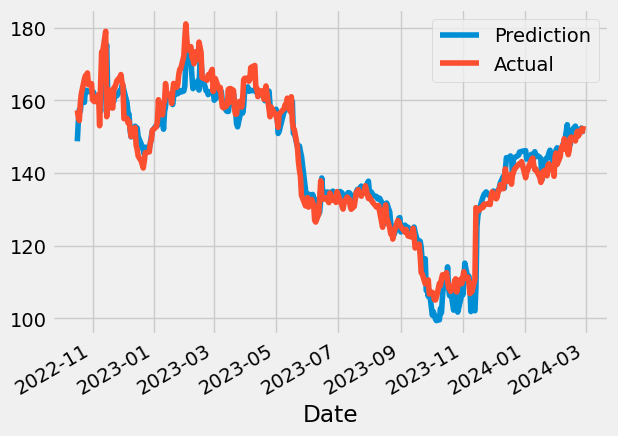

In [79]:
df5=pd.DataFrame({"Prediction": predictions_sr, "Actual": y_test})
df5.plot()

## Voting Classifier

In [80]:
vc_estimator= [('rfr', rf),
            ('lr',lr_model),
            ('xgb',xgb_model),
            ('gb',gb_model),
            ('ridge', ridge_model)
           ]
            

In [81]:
vc= VotingRegressor(estimators=vc_estimator, n_jobs=5) #, flatten_transform=True, verbose=False)

In [82]:
# fitting the regressor
vc.fit(X_train_scaled,y_train)

VotingRegressor(estimators=[('rfr', RandomForestRegressor()),
                            ('lr', LinearRegression()),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          impor...
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...)),
                            ('gb', GradientBoostingRegressor()),
                            ('ridge', Ridge())],
                n_jobs=5)

In [83]:
# prediction on Training Data
predictions_vc1=vc.predict(X_train_scaled)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, predictions_vc1))
print('Mean Squared Error:', metrics.mean_squared_error(y_train, predictions_vc1))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, predictions_vc1)))
print('R2 Score:', metrics.r2_score(y_train, predictions_vc1))
vc_r2_training= round((metrics.r2_score(y_train, predictions_vc1)),4)
vc_mse_training=round((metrics.mean_squared_error(y_train, predictions_vc1)),4)

Mean Absolute Error: 0.8570154083829594
Mean Squared Error: 2.2043924738541594
Root Mean Squared Error: 1.4847196617052525
R2 Score: 0.9993138594730753


In [84]:
# prediction on Testing Data
predictions_vc=vc.predict(X_test_scaled)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions_vc))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, predictions_vc))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predictions_vc)))
print('R2 Score:', metrics.r2_score(y_test, predictions_vc))
vc_r2_testing= round((metrics.r2_score(y_test, predictions_vc)),4)
vc_mse_testing=round((metrics.mean_squared_error(y_test, predictions_vc)),4)

Mean Absolute Error: 3.179787329380558
Mean Squared Error: 17.291227983124042
Root Mean Squared Error: 4.158272235330925
R2 Score: 0.9501717979491553


<Axes: xlabel='Date'>

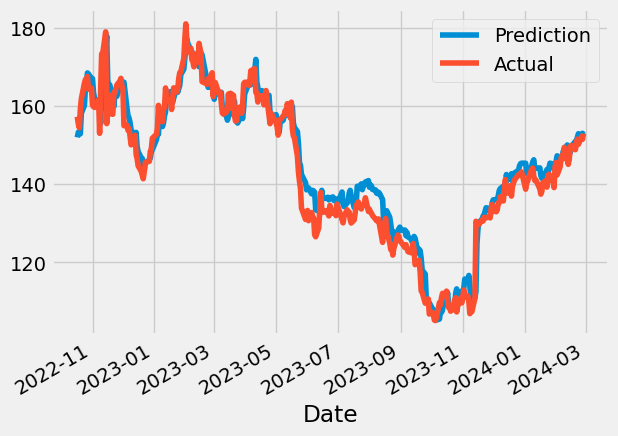

In [85]:
df6=pd.DataFrame({"Prediction": predictions_vc, "Actual": y_test})
df6.plot()

## Model Results

In [86]:
model_performance={"model":['Stacking_Model_Tr','Stacking_Model_Testing','VC_training','VC_testing'],
                   "r^2": [sr_r2_train, sr_r2_test,vc_r2_training,vc_r2_testing],
                   "MAE":[sr_mse_train,sr_mse_test,vc_mse_training,vc_mse_testing]}
model_performance_df=pd.DataFrame(model_performance)
model_performance_df=model_performance_df.set_index("model")
model_performance_df

,r^2,MAE
model,,
Stacking_Model_Tr,0.9977,7.3862
Stacking_Model_Testing,0.9503,17.2401
VC_training,0.9993,2.2044
VC_testing,0.9502,17.2912


<Axes: xlabel='index'>

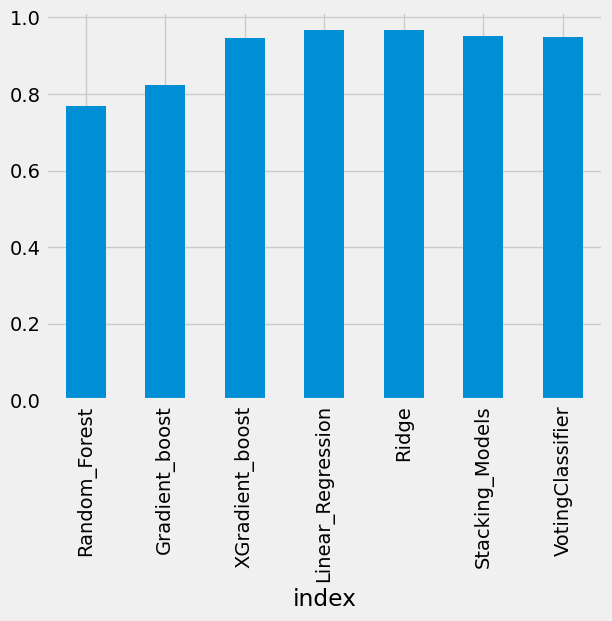

In [87]:

dict_results={"model":['Random_Forest','Gradient_boost','XGradient_boost','Linear_Regression','Ridge','Stacking_Models','VotingClassifier'], "r2":
              [rf_r2,gb_r2,xgb_r2,lrm_r2,ridge_r2,sr_r2_test,vc_r2_testing],"mse":
              [rf_mse,gb_mse,xgb_mse,lrm_mse,ridge_mse,sr_mse_test,vc_mse_testing]}
                                                                       
                                                           
result_df=pd.DataFrame(dict_results)
result_df=result_df.set_index("model")
result_df["r2"].plot(kind="bar",xlabel="index")

<Axes: xlabel='index'>

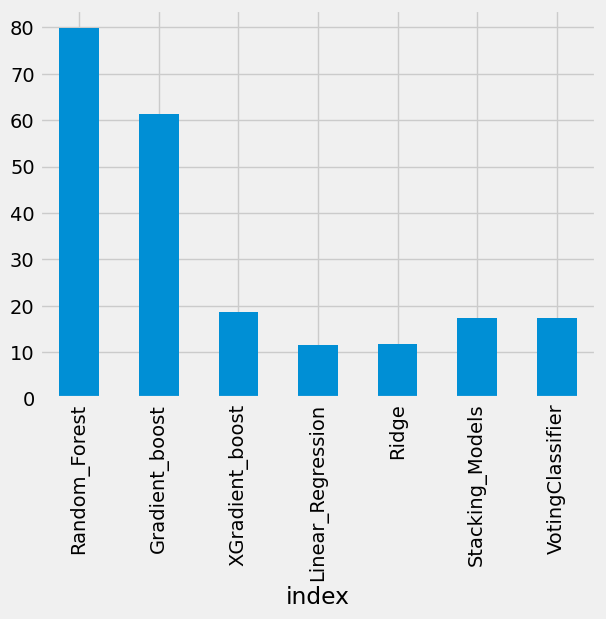

In [88]:
result_df["mse"].plot(kind="bar",xlabel="index")

In [89]:
# class RegressorModel(object):
#     def __init__(self, clf, params=None):
#         self.clf = clf(**params)
# def train(self, x_train, y_train):
#         self.clf.fit(x_train, y_train)
    
#     def fit(self,x,y):
#         return self.clf.fit(x,y)
    
#     def feature_importances(self,x,y):
#         return self.clf.fit(x,y).feature_importances_
    
#     def predict(self, x):
#         return self.clf.predict(x)